<a href="https://colab.research.google.com/github/LyseNdifo/recommandation-systems/blob/main/KPATOUKPA_NDIAYE_NGASSEU_WELEHELA_reco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet : systèmes de recommandation sur MovieLens**

- **Participants :**
  - Kpodjro KPATOUKPA
  - Serigne Bassirou NDIAYE
  - Lyse Priscille NGASSEU NDIFO
  - Orchelle Patricia WELEHELA TAWEUTEU

In [ ]:
!pip install -q cornac

In [ ]:
import cornac
import re
import pandas as pd
import cornac.data
from cornac.datasets import movielens

# **1. Présentation générale**

Ce projet s’inscrit dans le cadre du cours ***Introduction to Recommendation Systems*** et a pour objectif de mettre en pratique les notions fondamentales vues en cours à travers l’implémentation et la comparaison de différents modèles de recommandation sur un jeu de données au choix.

L’enjeu est de comprendre comment modéliser les préférences des utilisateurs et d’évaluer la qualité des recommandations produites. La problématique centrale est la suivante :  


<div align="center">
  <strong><em>Comment recommander efficacement des films à un utilisateur, en tenant compte à la fois de ses interactions passées et des caractéristiques des contenus ?</em></strong>
</div>


Pour y répondre, plusieurs modèles ont été étudiés et comparés :

- **Un modèle collaboratif de factorisation matricielle (MF)**, qui apprend des représentations latentes des utilisateurs et des films à partir de la matrice utilisateur–item.  
- **Des modèles content‑based utilisant des représentations textuelles des films**, parmi lesquels :
  - **Qwen :** utilisé dans ce projet pour construire des profils utilisateurs à partir des embeddings des descriptions de films.  
  - **BERT :** étudié comme modèle alternatif, afin de comparer l’impact de différentes représentations textuelles sur la qualité des recommandations.

L’ensemble de ces approches est évalué à l’aide de métriques **Recall@10** et **NDCG@10**, ce qui permet de comparer leurs performances et de discuter leurs forces et limites respectives.




# **2. Choix du dataset**

Dans ce projet, nous avons choisi d’utiliser le **jeu de données MovieLens 100K**, disponible via la bibliothèque **Cornac**.  

Ce dataset est particulièrement adapté car :  
- Il contient **100 000 évaluations** explicites (notes de 1 à 5) données par **943 utilisateurs** sur **1682 films**.  
- Chaque utilisateur a évalué au moins 20 films, ce qui garantit une base suffisamment dense pour l’entraînement.  
- Il inclut des **métadonnées textuelles** sur les films (titres, genres), ce qui est essentiel pour générer des **embeddings de langage** et enrichir les modèles de recommandation.  
- Il est largement utilisé dans la recherche et l’enseignement, ce qui permet de comparer facilement nos résultats avec des approches standards.  

En résumé, MovieLens 100K offre à la fois des **interactions utilisateur–item** et des **données textuelles** nécessaires pour tester un modèle basé sur des embeddings de langage et le comparer à une baseline collaborative comme la factorisation matricielle.


# **3. Préparation et chargement des données**

Avant de mettre en place nos modèles de recommandation, il est essentiel de préparer le jeu de données.  
Cette étape consiste à :  
- **Charger les interactions utilisateur–item** (notes explicites) depuis la source de données (Cornac).  
- **Enrichir les items et les utilisateurs avec des informations supplémentaires** issues des fichiers bruts (de MovieLens), afin de disposer de représentations exploitables pour la génération d’embeddings.  

Dans ce cadre, il est nécessaire de créer une nouvelle colonne textuelle regroupant les attributs descriptifs disponibles pour chaque film. Nous avons ainsi construit la colonne *movie_text*, qui concatène le titre nettoyé, l’année de sortie et les genres sous forme textuelle :

**movie_text = titre nettoyé + année + genres textuels**

En effet, l'encodage initial des genres sous forme binaire (colonnes indicatrices) ne permet pas de capturer les relations sémantiques entre les catégories. En revanche, une représentation textuelle rend possible l’utilisation de modèles de langage ou de techniques d’embeddings, capables d’apprendre des similarités et des proximités sémantiques entre les mots. Cette transformation est donc indispensable pour les approches basées sur le contenu et pour les modèles exploitant des embeddings.

Cette préparation garantit que les données soient prêtes, cohérentes et adaptées aux expérimentations qui suivront.





## **3.1. Chargement des données**

### **3.1.1. Chargement des interactions user-item**

In [ ]:
# Chargeons les interactions utilisateur–film depuis Cornac
ml_100k = movielens.load_feedback(variant='100K')


Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.data
will be cached into /Users/dst/.cornac/ml-100k/u.data


0.00B [00:00, ?B/s]

File cached!


In [ ]:
# Transformons en DataFrame avec noms de colonnes explicites
df_interactions = pd.DataFrame(ml_100k, columns=['user_id', 'item_id', 'rating'])

print("Dimensions :", df_interactions.shape)
print(df_interactions.head(2))

Dimensions : (100000, 3)
  user_id item_id  rating
0     196     242     3.0
1     186     302     3.0


### **3.1.2. Chargement des attributs des films**

Ce fichier contient des informations supplémentaires d'items nécessaire pour les enrichir.



In [ ]:
print("Dimensions :", movies.shape)
movies.head(2)

Dimensions : (1682, 24)


,item_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


#### **Nettoyage du titre**

Ici le nettoyage de la colonne du titre consiste à :
  - Extraire l'année de sortie entre parenthèses,
  - Renvoyer le titre sans année de sortie et l'année de sortie.

In [ ]:
# Fonction pour extraire l’année et nettoyer le titre

def split_title_and_year(title):
    """
    Extrait l'année entre parenthèses et renvoie :
    - le titre nettoyé
    - l'année (int ou None)
    """
    match = re.search(r'\((\d{4})\)', title)
    if match:
        year = int(match.group(1))
        clean_title = re.sub(r'\(\d{4}\)', '', title).strip()
        return clean_title, year
    else:
        return title, None


In [ ]:
movies.columns

Index(['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
       'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [ ]:
# Application de la fonction pour extraire l’année et nettoyer le titre

movies[['clean_title', 'year']] = movies['title'].apply(lambda x: pd.Series(split_title_and_year(x)))


In [ ]:
# Vérification
movies[['title', 'clean_title', 'year']].head(2)

,title,clean_title,year
0,Toy Story (1995),Toy Story,1995.0
1,GoldenEye (1995),GoldenEye,1995.0


In [ ]:
movies['year'].isna().sum()

np.int64(1)

In [ ]:
movies.loc[movies['year'].isna()]

,item_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,clean_title,year
266,267,unknown,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,unknown,NaN


**Constat et solution apportée** : Lors de l’analyse exploratoire, nous avons identifié un film dont le titre, l’année de sortie et l’ensemble des métadonnées textuelles étaient absents (valeur “unknown”) :  
  - Ce type d’entrée correspond à un placeholder historique du dataset MovieLens et ne peut être exploité ni par les modèles basés sur le contenu, ni par les méthodes d’embeddings.
  - Afin d’éviter d’introduire du bruit dans les modèles, cette observation a été supprimée du jeu de données.

In [ ]:
# Solution au constat
movies = movies[movies['title'] != 'unknown']


In [ ]:
# Conversion de la colonne année en entier
movies['year'] = movies['year'].astype('Int64')

In [ ]:
movies['year'].dtype

Int64Dtype()

In [ ]:
# Vérification
movies[['title', 'clean_title', 'year']].head(2)

,title,clean_title,year
0,Toy Story (1995),Toy Story,1995
1,GoldenEye (1995),GoldenEye,1995


#### **Création de la colonne *movie_text***

La nouvelle colonne *movie_text* est obtenue comme dit plus haut en :  
  - Concatènant le titre nettoyé, l’année de sortie et les genres sous forme textuelle :
    - *movie_text = titre nettoyé + année + genres textuels*

In [ ]:
genre_cols = [
    'unknown','Action','Adventure','Animation','Children','Comedy','Crime',
    'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
    'Romance','Sci-Fi','Thriller','War','Western'
]


In [ ]:
def build_movie_text(movies, genre_cols):
    """
    Crée les colonnes textuelles 'genres_text' et 'movie_text'.
    """

    # Construit la liste des genres actifs (valeur = 1)
    movies['genres_text'] = movies[genre_cols].apply(
        lambda row: ', '.join(
            genre for genre, val in row.items() if val == 1
        ),
        axis=1
    )

    # Construit le texte final du film (titre + année si présente + genres)
    movies['movie_text'] = movies.apply(
        lambda row: (
            f"{row['clean_title']} ({row['year']}) Genres: {row['genres_text']}"
            if pd.notna(row['year'])
            else f"{row['clean_title']} Genres: {row['genres_text']}"
        ),
        axis=1
    )

    return movies


In [ ]:
movies = build_movie_text(movies, genre_cols)

In [ ]:
movies[['title', 'clean_title', 'year', 'genres_text', 'movie_text']].head(2)


,title,clean_title,year,genres_text,movie_text
0,Toy Story (1995),Toy Story,1995,"Animation, Children, Comedy","Toy Story (1995) Genres: Animation, Children, ..."
1,GoldenEye (1995),GoldenEye,1995,"Action, Adventure, Thriller","GoldenEye (1995) Genres: Action, Adventure, Th..."


#### **Suppression des colonnes inutiles**

In [ ]:
# Suppresion des colonnes qui ne vont pas nous servir

movies = movies.drop(columns=['title', 'genres_text', 'release_date', 'video_release_date', 'IMDb_URL'])

In [ ]:
movies.columns

Index(['item_id', 'unknown', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'clean_title', 'year', 'movie_text'],
      dtype='object')

### **3.1.3. Chargement des attributs des utilisateurs**

Ce fichier contient des informations supplémentaires des utilisateurs nécessaire pour enrichir nos données pouvant impacter sur nos recommandations.

In [ ]:
users = pd.read_csv(
    '/content/drive/MyDrive/ml-100k/u.user',
    sep='|',
    encoding='latin-1',
    header=None,
    names=['user_id', 'age', 'gender', 'occupation', 'zip_code']
)


In [ ]:
print("Dimensions :", users.shape)
users.head(2)

Dimensions : (943, 5)


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [ ]:
users = users.drop(columns=['zip_code'])

In [ ]:
users.columns

Index(['user_id', 'age', 'gender', 'occupation'], dtype='object')

## **3.2. Fusion des trois sources**

Ici il est question de combiner nos trois sources de données afin de former notre dataset final.

### **3.2.1. Harmonisation des types des champs de jointure**

#### **Harmonisation du type du champ `item_id`**

In [ ]:
df_interactions['item_id'].dtype, movies['item_id'].dtype

(dtype('O'), dtype('int64'))

In [ ]:
df_interactions['item_id'] = df_interactions['item_id'].astype(int)

In [ ]:
df_interactions['item_id'].dtype, movies['item_id'].dtype

(dtype('int64'), dtype('int64'))

#### **Fusion 1 : interactions + films**

In [ ]:
# Fusion interactions + films

df_merged = df_interactions.merge(
    movies,
    on='item_id',
    how='left'
)



In [ ]:
df_merged.head(2)

,user_id,item_id,rating,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,clean_title,year,movie_text
0,196,242,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Kolya,1996,Kolya (1996) Genres: Comedy
1,186,302,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,L.A. Confidential,1997,"L.A. Confidential (1997) Genres: Crime, Film-N..."


In [ ]:
df_merged.columns

Index(['user_id', 'item_id', 'rating', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'clean_title', 'year',
       'movie_text'],
      dtype='object')

In [ ]:
df_interactions.shape

(100000, 3)

#### **Harmonisation du type du champ `user_id`**

In [ ]:
df_merged['user_id'].dtype, users['user_id'].dtype

(dtype('O'), dtype('int64'))

In [ ]:
df_merged['user_id'] = df_merged['user_id'].astype(int)

In [ ]:
df_merged['user_id'].dtype, users['user_id'].dtype

(dtype('int64'), dtype('int64'))

#### **Fusion 2 : Fusion1 + utilisateurs**

In [ ]:
#Fusion avec les utilisateurs

df = df_merged.merge(
    users,
    on='user_id',
    how='left'
)


In [ ]:
df.head(2)

,user_id,item_id,rating,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Sci-Fi,Thriller,War,Western,clean_title,year,movie_text,age,gender,occupation
0,196,242,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,Kolya,1996,Kolya (1996) Genres: Comedy,49,M,writer
1,186,302,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,L.A. Confidential,1997,"L.A. Confidential (1997) Genres: Crime, Film-N...",39,F,executive


In [ ]:
df.shape

(100000, 28)

## **3.3. Inspection du dataset finale**

### **3.3.1. Colonnes numériques**

In [ ]:
df.describe()

,user_id,item_id,rating,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,age
count,100000.00000,100000.000000,100000.000000,99991.000000,99991.000000,99991.000000,99991.000000,99991.000000,99991.000000,99991.000000,...,99991.000000,99991.000000,99991.000000,99991.000000,99991.000000,99991.000000,99991.000000,99991.000000,99991.0,100000.000000
mean,462.48475,425.530130,3.529860,0.000010,0.255913,0.137542,0.036053,0.071826,0.298347,0.080557,...,0.053175,0.049544,0.052455,0.194628,0.127311,0.218740,0.093988,0.018542,1987.749667,32.969850
std,266.61442,330.798356,1.125674,0.003162,0.436375,0.344421,0.186424,0.258202,0.457535,0.272155,...,0.224383,0.217003,0.222943,0.395916,0.333323,0.413394,0.291814,0.134900,14.138907,11.562623
min,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1922.0,7.000000
25%,254.00000,175.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1986.0,24.000000
50%,447.00000,322.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1994.0,30.000000
75%,682.00000,631.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1996.0,40.000000
max,943.00000,1682.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1998.0,73.000000


Après la fusion des tables, nous observons que les colonnes correspondant aux genres des films (Action, Comedy, Drama, etc.) ne comptaient que **99 991 valeurs non nulles**, alors que le jeu de données contient **100 000 interactions**.

Cette différence provient du film qui ne possédait aucune information descriptive : ni titre, ni année, ni genres. Les interactions associées à ce film contenaient donc des valeurs manquantes dans toutes les colonnes de genres.

Même après suppression de ce film non renseigné, comme fait plus haut, les valeurs manquantes restent présentes dans les colonnes de genres du DataFrame final, ce qui explique l’écart observé dans le résumé statistique.

**Solution** : Afin d’obtenir un jeu de données cohérent et exploitable par les modèles de recommandation, nous avons remplacé ces valeurs manquantes par 0, ce qui correspond à l’absence du genre pour l’interaction concernée.

In [ ]:
# Liste des colonnes de genres
genre_cols = [
    'unknown','Action','Adventure','Animation','Children','Comedy','Crime',
    'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
    'Romance','Sci-Fi','Thriller','War','Western'
]

# Remplacement des NaN par 0 dans les colonnes de genres
df[genre_cols] = df[genre_cols].fillna(0)


In [ ]:
df.describe()

,user_id,item_id,rating,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,age
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,99991.0,100000.000000
mean,462.48475,425.530130,3.529860,0.000010,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,...,0.053170,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540,1987.749667,32.969850
std,266.61442,330.798356,1.125674,0.003162,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,...,0.224373,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894,14.138907,11.562623
min,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1922.0,7.000000
25%,254.00000,175.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1986.0,24.000000
50%,447.00000,322.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1994.0,30.000000
75%,682.00000,631.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1996.0,40.000000
max,943.00000,1682.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1998.0,73.000000


Après nettoyage, toutes les colonnes de genres comptent désormais 100 000 valeurs non nulles.
La colonne **year** présente encore 9 valeurs manquantes (count = 99 991), ce qui correspond aux interactions associées au film dépourvu d’informations (titre, année, genres) dans le jeu de données d’origine.

Nous avons choisi de conserver ces valeurs manquantes dans year, car cette variable n’est pas utilisée directement dans les modèles de recommandation et il n’est pas pertinent d’imputer une année artificielle.

### **3.3.2. Colonnes catégorielles**

In [ ]:
df[['clean_title', 'movie_text', 'gender', 'occupation']].describe(include='object')

,clean_title,movie_text,gender,occupation
count,99991,99991,100000,100000
unique,1658,1663,2,21
top,Star Wars,"Star Wars (1977) Genres: Action, Adventure, Ro...",M,student
freq,583,583,74260,21957


In [ ]:
df['movie_text'].isna().sum()

np.int64(9)

In [ ]:
df['clean_title'].isna().sum()

np.int64(9)

Lors de l’analyse des variables textuelles (clean_title et movie_text), on constate qu’elles ne comptaient que **99 991 valeurs non nulles**, alors que le jeu de données contient **100 000 interactions**.

Cette différence provient de ce film dont le titre était « unknown ». Après avoir supprimé ce film dans la table des films, les interactions associées sont restées dans la table fusionnée, mais avec des colonnes film vides.

**Solution** : Comme ces lignes ne contiennent aucune information utile et ne seront utilisées ni par les modèles de recommandation classiques, ni par les embeddings (qui ne concernent que les films valides), nous retirons simplement ces 9 lignes pour obtenir un jeu de données propre.

In [ ]:
df = df.dropna(subset=['clean_title'])

Après suppression des 9 interactions associées au film « unknown », le jeu de données final contient 99 991 lignes.

In [ ]:
df.shape

(99991, 28)

In [ ]:
df.to_parquet("movies_clean.parquet", index=False)

## **3.4. Visualisation**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

### **3.4.1. Distribution des notes**

On note que la distribution des notes est fortement biaisée vers les évaluations positives : les notes **3, 4 et 5** représentent l’immense majorité des interactions, tandis que les notes **1 et 2** sont relativement rares. Cela reflète un comportement classique des utilisateurs, qui ont tendance à davantage noter les films qu’ils apprécient.

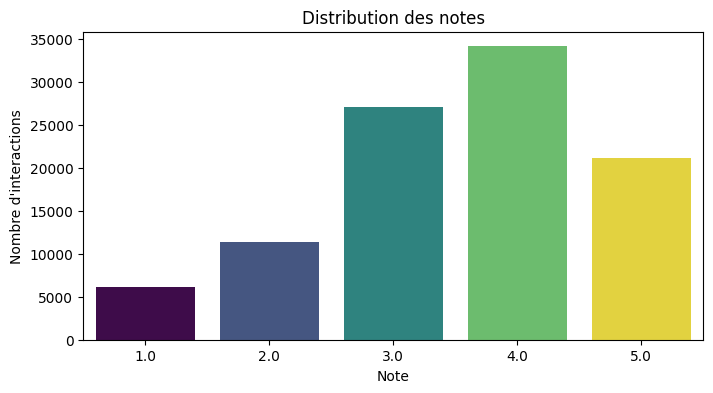

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='rating', hue='rating', palette='viridis', legend=False)
plt.title("Distribution des notes")
plt.xlabel("Note")
plt.ylabel("Nombre d'interactions")

plt.savefig("/content/drive/MyDrive/ml-100k/images/distribution_notes.png",
            dpi=300, bbox_inches='tight')

plt.show()



### **3.4.2. Nombre d’interactions par utilisateur**

La distribution du nombre d’interactions par utilisateur montre une forte hétérogénéité : certains utilisateurs notent plusieurs centaines de films, tandis que d’autres n’en notent qu’une vingtaine. La majorité des utilisateurs ont un volume d’interactions relativement faible, ce qui crée **une distribution très déséquilibrée**.

- **Hypothèse** : Cette distribution suggère que les utilisateurs n’ont pas tous le même niveau d’engagement. Certains semblent passionnés ou habitués à noter régulièrement, tandis que d’autres n’interagissent qu’occasionnellement. Cela peut refléter des différences d’habitudes, de disponibilité ou d’intérêt pour la plateforme.

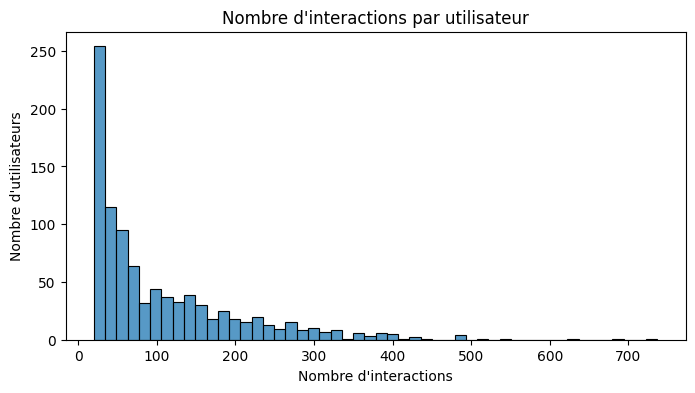

In [ ]:
ratings_per_user = df.groupby('user_id').size()

plt.figure(figsize=(8,4))
sns.histplot(ratings_per_user, bins=50, kde=False)
plt.title("Nombre d'interactions par utilisateur")
plt.xlabel("Nombre d'interactions")
plt.ylabel("Nombre d'utilisateurs")
plt.savefig("/content/drive/MyDrive/ml-100k/images/nb_interactions_per_user.png",
            dpi=300, bbox_inches='tight')
plt.show()


### **3.4.3. Nombre d’interactions par film**

La distribution du nombre d’interactions par film est très déséquilibrée : quelques films reçoivent un grand nombre de notes, parfois plusieurs centaines, tandis que la majorité n’en reçoivent que très peu.
- **Hypothèses :**
  - Certains films sont probablement plus connus, ou plus visibles dans le catalogue, ce qui augmente leur probabilité d’être notés.
  - À l’inverse, d’autres films peuvent être moins populaires, moins diffusés ou moins mis en avant, ce qui réduit leur exposition auprès des utilisateurs.

Cette observation suggère une forte **diversité dans la visibilité et l’intérêt** suscité par les films du dataset.

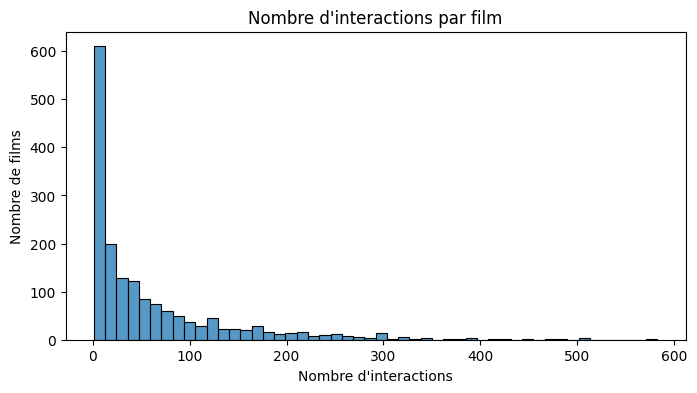

In [ ]:
ratings_per_item = df.groupby('item_id').size()

plt.figure(figsize=(8,4))
sns.histplot(ratings_per_item, bins=50, kde=False)
plt.title("Nombre d'interactions par film")
plt.xlabel("Nombre d'interactions")
plt.ylabel("Nombre de films")
plt.savefig("/content/drive/MyDrive/ml-100k/images/nb_interaction_per_film.png",
            dpi=300, bbox_inches='tight')
plt.show()


### **3.4.4. Répartition des genres**

- La répartition des genres montre une forte dominance des films de type *Drama*, suivis par *Comedy*, *Action*, *Thriller* et *Romance* : ces genres regroupent la majorité des interactions, ce qui peut s’expliquer par leur popularité générale et leur forte présence dans le catalogue.
- À l’inverse, des genres comme *Documentary*, *Film-Noir*, *Western* ou *Fantasy* sont beaucoup moins représentés : cela peut refléter une offre plus limitée, une moindre visibilité ou un public plus restreint pour ces catégories.

Cette distribution suggère une diversité importante dans les préférences des utilisateurs, mais avec une concentration notable autour de quelques genres très populaires.

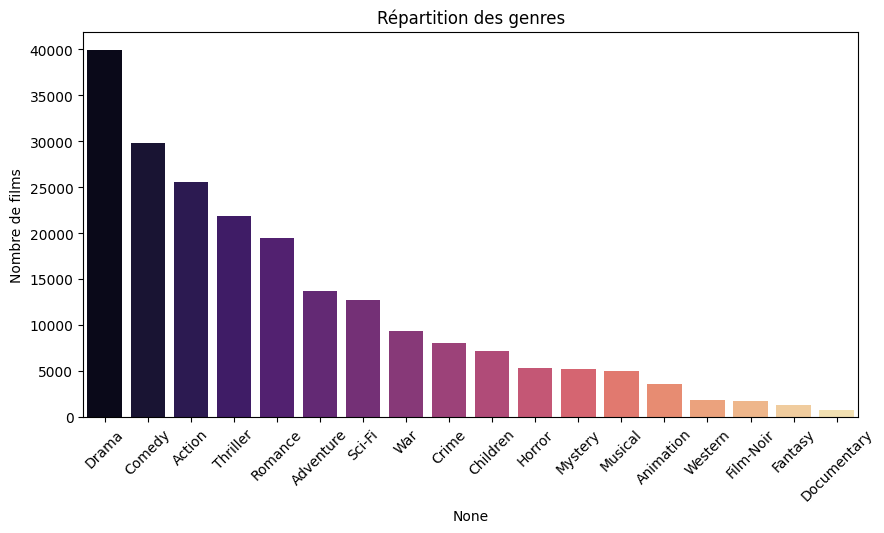

In [ ]:
genre_cols = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary',
              'Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance',
              'Sci-Fi','Thriller','War','Western']

genre_counts = df[genre_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(
    x=genre_counts.index,
    y=genre_counts.values,
    hue=genre_counts.index,
    palette='magma',
    legend=False
)
plt.xticks(rotation=45)
plt.title("Répartition des genres")
plt.ylabel("Nombre de films")

plt.savefig("/content/drive/MyDrive/ml-100k/images/repartition_genres.png",
            dpi=300, bbox_inches='tight')

plt.show()


### **3.4.5. Distribution des années de sortie**

- La distribution des années de sortie est fortement concentrée dans les années 1990, en particulier entre 1994 et 1997.
  - Cette sur‑représentation s’explique par la période de collecte du dataset (1997–1998), durant laquelle les utilisateurs notaient principalement des films récents pour l’époque.

- À l’inverse, les films anciens sont très peu présents, probablement en raison d’une moindre disponibilité et d’un intérêt plus limité au moment de la collecte.

- La chute observée en 1998 s’explique par le fait que l’année est incomplète dans le dataset.

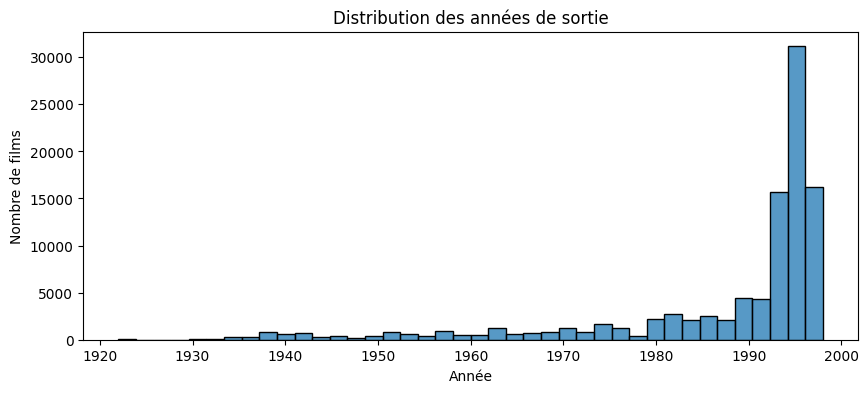

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(df['year'].dropna(), bins=40)
plt.title("Distribution des années de sortie")
plt.xlabel("Année")
plt.ylabel("Nombre de films")
plt.savefig("/content/drive/MyDrive/ml-100k/images/distribution_annee_sortie.png",
            dpi=300, bbox_inches='tight')
plt.show()


### **3.4.6. Conclusion générale - Visualisation**

L’exploration du dataset révèle une structure très déséquilibrée, tant du côté des utilisateurs que des films. On a pu constater que :

- les notes sont très positives : biais de notation

- les utilisateurs sont très inégaux : certains notent 5 films, d’autres 300+

- les films sont très inégaux : certains ont 400 notes, d’autres 1 seule

- les genres sont très déséquilibrés

- les années sont concentrées dans une période temporelle bien précise : les années 1990

Ces observations permettent de mieux comprendre la nature du dataset et d’anticiper les défis potentiels pour les étapes suivantes, notamment la préparation des données car elles peuvent influencer les performances de nos modèles de recommandation.

## **3.5. Préparation des données**

### **3.5.1. Filtrage des utilisateurs trop peu actifs**

Ici, il est question d’identifier les utilisateurs qui disposent d’un volume d’interactions suffisant pour être considérés comme informatifs. Les profils ayant seulement une ou deux notes ne permettent pas de dégager des préférences exploitables, d’où l’application d’un seuil minimal d’interactions.

Le seuil de **cinq interactions** a été choisi car il permet d’éliminer les profils presque vides tout en conservant la majorité des utilisateurs, dont l’activité se situe principalement entre **5 et 20 interactions**. De plus, ce seuil ne déforme pas la distribution et garantit un volume de données suffisamment large pour la suite de l’analyse.




In [ ]:
min_user_interactions = 5

In [ ]:
active_users = ratings_per_user[ratings_per_user >= min_user_interactions].index
df = df[df['user_id'].isin(active_users)]


### **3.5.2. Filtrage des films trop peu notés**  

Ici, il est question de filtrer les films très peu notés. Les films qui n’ont reçu qu’une ou deux interactions apportent très peu d’information et ne permettent pas de dégager une tendance fiable. Nous retenons donc uniquement les films ayant au **moins cinq notes**.

Le seuil de cinq notes a été retenu car il supprime les films très peu visibles, conserve la majorité des titres (souvent notés entre 5 et 20 fois), ne déforme pas la distribution et maintient un dataset suffisamment riche tout en préservant la structure générale du catalogue.



In [ ]:
min_item_interactions = 5

In [ ]:

active_items = ratings_per_item[ratings_per_item >= min_item_interactions].index
df = df[df['item_id'].isin(active_items)]

### **3.5.3. Recalcul des distributions après filtrage**

Cette étape consiste à recalculer les distributions après filtrage afin de vérifier que la sparsité du dataset a été réduite et que les profils restants sont plus stables. Le filtrage appliqué supprime uniquement les cas très peu renseignés, sans chercher à éliminer les valeurs élevées, qui restent informatives pour la suite de l’analyse.

In [ ]:
ratings_per_user = df.groupby('user_id')['rating'].count()


In [ ]:
ratings_per_item = df.groupby('item_id')['rating'].count()


In [ ]:
ratings_per_user.describe()

,rating
count,943.000000
mean,105.278897
std,99.120515
min,19.000000
25%,33.000000
50%,64.000000
75%,147.000000
max,648.000000


In [ ]:
ratings_per_item.describe()

,rating
count,1348.000000
mean,73.648368
std,83.951542
min,5.000000
25%,15.000000
50%,43.000000
75%,100.000000
max,583.000000


#### **Observation**

Après filtrage, la distribution du nombre d’interactions par utilisateur et par film devient nettement plus stable :  

- Les utilisateurs restants disposent tous d’au moins 19 interactions.
- Les films restants disposent tous d’au moins 5 notes.

Ce nettoyage élimine les profils quasi vides, renforce la densité du dataset et garantit des signaux suffisamment riches pour l’apprentissage des embeddings.

### **3.5.4. Réindexage des IDs et Normalisation des notes**

Avant d’entamer la phase de modélisation, il est nécessaire de préparer les identifiants et les valeurs de notes. Cette étape consiste à réindexer les utilisateurs et les films avec des identifiants consécutifs, puis à normaliser les notes (par centrage global) afin de faciliter l’apprentissage et d’assurer une meilleure stabilité des modèles.


In [ ]:
df['user_idx'] = df['user_id'].astype('category').cat.codes
df['item_idx'] = df['item_id'].astype('category').cat.codes


- Les colonnes `user_idx`et `item_idx` sont conservées car elles constituent les identifiants consécutifs utilisés par les modèles.
- Les identifiants d’origine (`user_id`, `item_id`) sont également maintenus afin de permettre l’interprétation des résultats et les jointures éventuelles avec d’autres tables.

In [ ]:
df['rating_norm'] = df['rating'] - df['rating'].mean()

- La colonne `rating` est conservée comme valeur de référence pour l’évaluation et l’interprétation des résultats.

- La colonne `rating_norm` constitue une version centrée des notes, utilisée uniquement pour faciliter l’apprentissage des modèles.

### **3.5.5. Split train/test stratifié**  

Avant d’entraîner les modèles, il est nécessaire de séparer les données en ensembles d’entraînement et de test. Nous utilisons un split stratifié afin de garantir que chaque utilisateur et chaque film présents dans le test apparaissent également dans l’entraînement, ce qui évite les situations où un modèle devrait prédire pour un utilisateur ou un item qu’il n’a jamais vu.



In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
def stratified_user_split(df, user_col='user_idx', test_size=0.2, random_state=42):
    """
    Réalise un split train/test stratifié par utilisateur.

    Retourne :
    train_df : pd.DataFrame
    test_df : pd.DataFrame
    """

    train_list = []
    test_list = []

    for user, group in df.groupby(user_col):
        if len(group) >= 2:  # minimum pour split
            train_g, test_g = train_test_split(
                group,
                test_size=test_size,
                random_state=random_state
            )
        else:
            # si un utilisateur n'a qu'une interaction
            train_g = group
            test_g = None

        train_list.append(train_g)
        if test_g is not None:
            test_list.append(test_g)

    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    return train_df, test_df


In [ ]:
train_df, test_df = stratified_user_split(df, user_col='user_idx', test_size=0.2, random_state=42)

In [ ]:
print('Taille du clean df', df.shape)
print('Taille du train', train_df.shape)
print('Taille du test', test_df.shape)

Taille du clean df (99278, 31)
Taille du train (79039, 31)
Taille du test (20239, 31)


In [ ]:
# Vérification si tous les utilisateurs du test sont dans le train
set(test_df['user_idx']).issubset(set(train_df['user_idx']))

True

In [ ]:
# Vérification si tous les items du test sont dans le train
set(test_df['item_idx']).issubset(set(train_df['item_idx']))

True

In [ ]:
# train_df.to_parquet("train.parquet", index=False)
# test_df.to_parquet("test.parquet", index=False)
# df.to_parquet("clean.parquet", index=False)


# **4. Baseline : Factorisation Matricielle (MF)**

Pour établir une première ligne de référence (baseline) dans l’évaluation des modèles de recommandation, nous optons pour la **Factorisation Matricielle (MF)**. Ce modèle permet de capturer les interactions latentes entre utilisateurs et items à partir de la matrice de notes, et sert ainsi de point de comparaison simple et cohérent pour les modèles que nous testerons ensuite.

- **Données d'entrée :** `train_df`, les triplets $(𝑢,𝑖,𝑟_{𝑢𝑖})$ pour l’entraînement

- **Hyperparamètres :** k (dimension latente), lambda_reg, n_epochs

-  **Sorties :** notes prédites, qui vont servir à générer un Top‑N

- **Métriques d’évaluation** : RMSE, MAE, MAPE, Recall@M, NDCG@M




In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## **4.1. Initialisation des matrices latentes P et Q**

In [ ]:
# Identifions les colonnes utiles pour la MF et recalculons les index

mf_df = train_df[["user_idx", "item_idx", "rating"]].copy()


In [ ]:
# Recalculons les index
unique_users = mf_df["user_idx"].unique()
unique_items = mf_df["item_idx"].unique()

user2new = {u: idx for idx, u in enumerate(unique_users)}
item2new = {i: idx for idx, i in enumerate(unique_items)}

mf_df["user_idx"] = mf_df["user_idx"].map(user2new)
mf_df["item_idx"] = mf_df["item_idx"].map(item2new)


In [ ]:
# Récupération des dimensions : On a besoin du nombre d’utilisateurs et d’items pour initialiser les matrices

n_users = mf_df["user_idx"].max() + 1
n_items = mf_df["item_idx"].max() + 1

print('n_users :', n_users)
print('n_items :', n_items)


n_users : 943
n_items : 1348


In [ ]:
k = 20  # dimension latente

In [ ]:
# Initialisation des matrices latentes P et Q

rng = np.random.default_rng(seed=42)

P = rng.normal(0, 0.1, size=(n_users, k))
Q = rng.normal(0, 0.1, size=(n_items, k))

print('Taille de P :', P.shape)
print('Taille de Q : ', Q.shape)


Taille de P : (943, 20)
Taille de Q :  (1348, 20)


On a donc :
- P[u] = vecteur latent utilisateur

- Q[i] = vecteur latent item

## **4.2. Apprentissage du modèle de factorisation matricielle (SGD)**

L’apprentissage du modèle repose sur la factorisation matricielle, dont l’objectif est d’approximer la matrice utilisateur‑item $(R)$ par le produit de deux matrices latentes :  
- $(P)$, représentant les facteurs latents des utilisateurs,  
- $(Q)$, représentant les facteurs latents des items.

Le principe consiste à apprendre ces deux matrices de manière à minimiser l’erreur entre les notes observées et les notes prédites par le modèle. À chaque itération, les vecteurs latents $(P_u)$ et $(Q_i)$ sont **mis à jour** afin de **réduire l’erreur de prédiction**, selon une procédure d’optimisation par **descente de gradient régularisée**.

Pour suivre la qualité de l’apprentissage et vérifier que le modèle converge correctement, nous mesurons à chaque itération le **Root Mean Squared Error (RMSE)** sur les données d’entraînement. Le RMSE permet d’observer la diminution progressive de l’erreur et d’identifier un éventuel surapprentissage ou une stagnation du modèle.

Cette phase d’apprentissage permet ainsi d’obtenir des représentations latentes cohérentes, qui seront ensuite utilisées pour estimer la préférence de chaque utilisateur pour les différents items et générer des recommandations personnalisées.


In [ ]:
# Fonction de prédiction

def predict_single(u_idx, i_idx, P, Q):
    return np.dot(P[u_idx], Q[i_idx])


In [ ]:
# Fonction RMSE

def rmse(df, P, Q):
    preds = df.apply(
        lambda row: predict_single(int(row["user_idx"]), int(row["item_idx"]), P, Q),
        axis=1
    )
    mse = np.mean((df["rating"].values - preds.values) ** 2)
    return np.sqrt(mse)




In [ ]:
# Boucle d’apprentissage (SGD)

lambda_reg = 0.01
lr = 0.01
n_epochs = 20

rmse_history = []

for epoch in range(n_epochs):
    df_shuffled = mf_df.sample(frac=1.0, random_state=epoch)

    for _, row in df_shuffled.iterrows():
        u = int(row["user_idx"])
        i = int(row["item_idx"])
        r_ui = row["rating"]

        r_hat = np.dot(P[u], Q[i])
        err = r_ui - r_hat

        p_u = P[u].copy()
        q_i = Q[i].copy()

        P[u] += lr * (err * q_i - lambda_reg * p_u)
        Q[i] += lr * (err * p_u - lambda_reg * q_i)

    rmse_epoch = rmse(mf_df, P, Q)
    rmse_history.append(rmse_epoch)
    print(f"Epoch {epoch+1}/{n_epochs} - RMSE train = {rmse_epoch:.4f}")



Epoch 1/20 - RMSE train = 2.4961
Epoch 2/20 - RMSE train = 1.1975
Epoch 3/20 - RMSE train = 1.0036
Epoch 4/20 - RMSE train = 0.9418
Epoch 5/20 - RMSE train = 0.9099
Epoch 6/20 - RMSE train = 0.8870
Epoch 7/20 - RMSE train = 0.8682
Epoch 8/20 - RMSE train = 0.8494
Epoch 9/20 - RMSE train = 0.8331
Epoch 10/20 - RMSE train = 0.8168
Epoch 11/20 - RMSE train = 0.7997
Epoch 12/20 - RMSE train = 0.7826
Epoch 13/20 - RMSE train = 0.7677
Epoch 14/20 - RMSE train = 0.7526
Epoch 15/20 - RMSE train = 0.7391
Epoch 16/20 - RMSE train = 0.7254
Epoch 17/20 - RMSE train = 0.7135
Epoch 18/20 - RMSE train = 0.7017
Epoch 19/20 - RMSE train = 0.6909
Epoch 20/20 - RMSE train = 0.6820


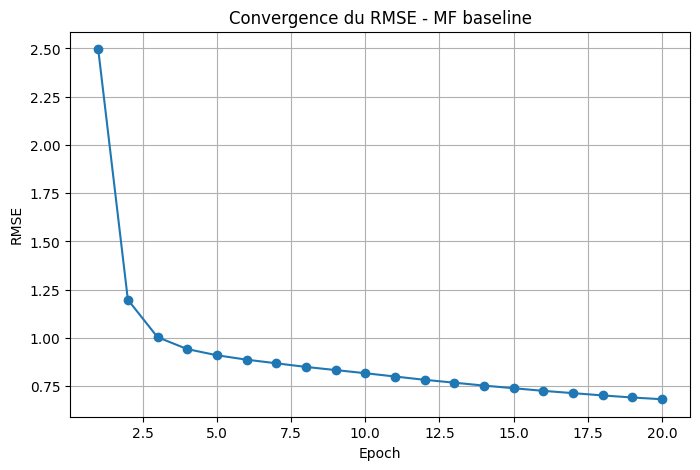

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), rmse_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Convergence du RMSE - MF baseline")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/rmse_mf_baseline.png", dpi=300)
plt.show()


**Interprétation :**

- Le RMSE diminue régulièrement au fil des itérations, passant de **2.49** à **0.68** après **20 époques**.
- Cette décroissance monotone montre que le modèle apprend correctement les représentations latentes des utilisateurs et des items.
- La valeur finale de **0.68** avec **SGD**, sur une échelle de notes allant de 1 à 5, indique que le modèle se **trompe en moyenne d’environ 0.68 point par prédiction**, ce qui correspond à une performance solide pour une baseline de factorisation matricielle.

Pour la baseline MF, nous avons utilisé uniquement le RMSE sur l’ensemble d’entraînement afin d’observer la convergence. Une validation croisée pourra être ajoutée dans les modèles plus avancés afin d’optimiser les hyperparamètres et éviter le surapprentissage.

## **4.3. Prédiction et Évaluation du modèle MF**

### **4.3.1. Prédiction du modèle MF**

Après l’apprentissage, les matrices latentes $(P)$ et $(Q)$ permettent d’estimer la préférence d’un utilisateur pour un item.  
La prédiction se fait par le produit scalaire : **$\hat{r}_{ui} = P_u \cdot Q_i$**

Ce score représente une **préférence estimée**, utilisée pour classer les items non vus et générer les recommandations.

In [ ]:
# Prédiction d'une note pour un couple user–item
def predict_rating(user_idx, item_idx, P, Q):
    return predict_single(user_idx, item_idx, P, Q)



In [ ]:
predict_rating(196, 45, P, Q)

np.float64(3.684843182347685)

- Le modèle estime que l’**utilisateur 196** aurait une préférence de **3.68** pour l’**item 45**.

- La valeur prédite $(\hat r_{ui} = 3.68$) ne correspond pas à une note réelle, mais à un score de préférence latente. Elle va permettre de comparer les items entre eux afin de **générer les recommandations Top‑N**.

### **4.3.2. Évaluation du modèle MF**

Pour évaluer la performance du modèle, nous comparons les notes prédites aux notes observées dans le jeu de test.  
Nous utilisons deux métriques :  
- le **MAE :** qui mesure l’erreur moyenne entre les prédictions et les valeurs réelles,  
- le **MAPE :** qui exprime cette erreur en pourcentage.  

Ces mesures permettent de contrôler la qualité des prédictions et de vérifier que le modèle converge vers une approximation cohérente des préférences des utilisateurs.

In [ ]:
# Évaluation du modèle

test_predictions = test_df.apply(lambda row: predict_rating(int(row["user_idx"]), int(row["item_idx"]), P, Q), axis=1)


In [ ]:
mae_test = mean_absolute_error(test_df["rating"], test_predictions)
mape_test = mean_absolute_percentage_error(test_df["rating"], test_predictions)
print("MAE sur l'ensemble de test :", mae_test)
print(f"MAPE sur l'ensemble de test : {mape_test * 100:.2f} %")


MAE sur l'ensemble de test : 1.0323965967791466
MAPE sur l'ensemble de test : 36.82 %


**Interprétations :**
- Le **MAE** sur l’ensemble de test est de **1.03**, ce qui signifie que le modèle se trompe en moyenne d’un point sur la note réelle.
- Le **MAPE** sur l’ensemble de test est de **36.82 %**, ce qui indique que l’erreur moyenne représente environ **37 %** de la note réelle.
  - Cette valeur peut sembler élevée, mais elle est attendue dans un contexte où les notes sont faibles (1 à 5), ce qui rend l’erreur relative particulièrement sensible. En effet, sur une telle échelle, une erreur absolue d’un seul point peut représenter entre 20 % et 100 % de la valeur réelle.
  - Par exemple, passer de 2 à 3 correspond à une erreur relative de 50 %, tandis qu’une erreur de 1 point autour de 4 ne représente qu’environ 25 %. Ainsi, un MAPE situé autour de 30–40 % est tout à fait typique pour ce type de modèle.

Ces résultats montrent que le modèle capture une partie des préférences utilisateurs, mais reste limité en précision, ce qui ouvre la voie à des améliorations (biais utilisateur/item, régularisation, tuning des hyperparamètres) et à d'autres modèles.

## **4.4. ÉTAPE 4 - Génération des recommandations Top‑N et Évaluation de leur qualité**

### **4.4.1. Génération des recommandations Top‑N**

Une fois les scores de préférence prédits pour chaque couple **utilisateur–item**, nous pouvons générer des recommandations.

Pour un utilisateur donné, l’idée est de trier les items non encore vus selon leur score prédit, puis de sélectionner les **Top‑N** ayant les valeurs les plus élevées.

Cette étape permet d’obtenir une liste personnalisée d’items que le modèle estime les plus susceptibles de lui plaire.

In [ ]:
# Identifions les items déjà notés par l’utilisateur
def get_seen_items(df, user_idx):
    return set(df[df["user_idx"] == user_idx]["item_idx"].values)


In [ ]:
# Générons les prédictions pour tous les items non vus

def predict_all_items_for_user(user_idx, P, Q, all_items, seen_items):
    preds = []
    for item_idx in all_items:
        if item_idx not in seen_items:
            pred = predict_rating(user_idx, item_idx, P, Q)
            preds.append((item_idx, pred))
    return preds


In [ ]:
# Trions et sélectionnons les Top‑N

def top_n_recommendations(user_idx, P, Q, df, N=5):
    all_items = df["item_idx"].unique()
    seen_items = get_seen_items(df, user_idx)

    preds = predict_all_items_for_user(user_idx, P, Q, all_items, seen_items)

    preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)

    return preds_sorted[:N]


#### **Remarques :**
- Les valeurs qui résultent de ***top_n_recommendations*** ne représentent pas des notes réelles sur une échelle de 1 à 5 : un score comme 5.80 ne signifie donc pas que l’utilisateur attribuerait une note de 5.80/5.
- Ces scores correspondent plutôt à des scores de préférence latente : ils servent donc avant tout à **ordonner les items entre eux**.
  - Autrement dit, l’ordre décroissant des scores reflète **l’ordre de recommandation** : **plus le score est élevé, plus l’item est jugé pertinent** pour un utilisateur.

#### **Application**

In [ ]:
# Application
user = 12
recommendations = top_n_recommendations(user, P, Q, mf_df, N=10)

print("Top‑10 recommandations pour l’utilisateur", user)
for item, score in recommendations:
    print(f"Item {item} -> score prédit = {score:.2f}")


Top‑10 recommandations pour l’utilisateur 12
Item 439 -> score prédit = 5.80
Item 198 -> score prédit = 5.61
Item 435 -> score prédit = 5.55
Item 816 -> score prédit = 5.30
Item 1151 -> score prédit = 5.28
Item 75 -> score prédit = 5.25
Item 927 -> score prédit = 5.23
Item 917 -> score prédit = 5.22
Item 481 -> score prédit = 5.22
Item 962 -> score prédit = 5.11


On peut donc voir que, parmi tous les items que **l’utilisateur 12** n’a pas encore vus, le modèle estime que :

- **Item 439** est celui qui a **la plus forte probabilité de lui plaire**,
- suivi de Item 198,
- puis Item 435,
- etc.

### **4.4.2. Évaluation de la qualité des recommandations Top‑N**

Après avoir entraîné le modèle de factorisation matricielle et généré des listes de recommandations pour chaque utilisateur, il est nécessaire d’évaluer la qualité de ces recommandations. Contrairement aux métriques d’erreur (MAE, MAPE) qui mesurent la précision des prédictions de notes, l’évaluation d’une liste de recommandations repose sur des métriques de *ranking* et de *pertinence*.

**Dans ce cadre, nous considérons qu’un item est pertinent pour un utilisateur si sa note réelle dans le jeu de test est supérieure ou égale à 4**. Cette définition correspond à l’idée qu’un item noté 4 ou 5 reflète une appréciation positive et constitue une recommandation utile.

L’objectif est donc d’évaluer la capacité du modèle à :

- **identifier** les items pertinents (pertinence),
- **les placer en tête** de la liste recommandée (qualité du classement).

Pour cela, nous utilisons deux métriques :

- **F1@N**, qui combine précision et rappel pour mesurer la qualité globale de la liste recommandée,
- **NDCG@N**, qui évalue la qualité du classement en tenant compte de la position des items pertinents dans les Top‑N.

Ces deux métriques permettent d’obtenir une évaluation complète et équilibrée de la performance du modèle en recommandation.


In [ ]:
def evaluate_recommendations(P, Q, train_df, test_df, M=5):
    users = test_df["user_idx"].unique()

    # f1_scores = []
    ndcg_scores = []
    recall_scores = []

    for user in users:

        # Items pertinents dans le test (notes >= 4)
        user_test = test_df[test_df["user_idx"] == user]
        relevant_items = set(user_test[user_test["rating"] >= 4]["item_idx"])

        if len(relevant_items) == 0:
            continue  # pas de pertinents -> on ignore cet utilisateur

        # Top-M recommandations
        recs = top_n_recommendations(user, P, Q, train_df, N=M)
        rec_items = [item for item, score in recs]

        # Precision@M
        good_recs = len([i for i in rec_items if i in relevant_items])
        precision = good_recs / M

        # Recall@M
        recall = good_recs / len(relevant_items)
        recall_scores.append(recall)

        # # F1@M
        # if precision + recall > 0:
        #     f1 = 2 * (precision * recall) / (precision + recall)
        # else:
        #     f1 = 0
        # f1_scores.append(f1)

        # NDCG@M
        dcg = 0
        for rank, item in enumerate(rec_items, start=1):
            rel = 1 if item in relevant_items else 0
            dcg += rel / np.log2(rank + 1)

        # IDCG = DCG idéal (tous les pertinents en tête)
        ideal_rel_count = min(M, len(relevant_items))
        idcg = sum([1 / np.log2(i + 1) for i in range(1, ideal_rel_count + 1)])

        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)

    # Moyenne sur les utilisateurs
    return np.mean(recall_scores), np.mean(ndcg_scores) #, np.mean(f1_scores)


In [ ]:
ndcg_m, recall_m = evaluate_recommendations(P, Q, mf_df, test_df, M=10)

print(f"MF - Recall@10 : {recall_m:.4f}")
print(f"MF - NDCG@10 : {ndcg_m:.4f}")


MF - Recall@10 : 0.0184
MF - NDCG@10 : 0.0122


**Interprétation :**
- **Recall@10 = 0.0184** : Ce score indique que le modèle retrouve très peu d’items réellement pertinents (notes ≥ 4) parmi ceux que l’utilisateur a appréciés dans le test. Autrement dit, même si l’utilisateur possède plusieurs films pertinents, la majorité ne sont pas retrouvés dans les dix recommandations proposées.

- **NDCG@10 = 0.0122 :** Ce score montre que, même lorsque des items pertinents apparaissent dans les recommandations, ils sont généralement mal classés. Le gain cumulé (DCG) reste donc très faible, ce qui conduit à un NDCG proche de zéro.




**Conclusion :**

- Les scores obtenus restent faibles (Recall@10 = 0.0184, NDCG@10 = 0.0122), ce qui montre que, malgré l’utilisation d’une régularisation, le modèle de factorisation matricielle peine à identifier et à bien classer les items pertinents dans les dix premières recommandations.

- Ces performances limitées s’expliquent par la simplicité du modèle (absence de biais utilisateur et item) et la forte sparsité de la matrice utilisateur‑item, dont la majorité des interactions possibles ne sont pas observées.
  - Le modèle capture une structure latente minimale, mais reste insuffisant pour produire des recommandations de haute qualité sans extensions supplémentaires.

## **4.5. Solution proposée : une approche basée sur les embeddings de modèles de langage**

Afin d’améliorer la qualité des recommandations, nous complétons la baseline MF par une approche basée sur des **embeddings issus de modèles de langage**. Ces modèles transforment le texte descriptif des films (titre, genres, etc.) en vecteurs denses capturant leur proximité sémantique. Cette représentation ouvre la voie à un système de recommandation de type ***content‑based***, plus expressif que la factorisation matricielle.

Nous évaluons deux variantes :  
- un modèle basé sur **Sentence‑BERT**
- un modèle basé sur **Qwen Embedding**

# **5. Qwen Embedding**

Nous utilisons **Qwen Embedding**, un modèle de langage pré‑entraîné permettant de générer des représentations vectorielles denses à partir du texte descriptif des films. Ces embeddings sont ensuite utilisés pour construire un système de recommandation de type *content‑based*.

- **Données d’entrée :** `movie_text`, `train_df`  
- **Hyperparamètres :**  
  - modèle utilisé : **Qwen2.5-0.5B-Instruct**,  
  - dimension des embeddings : **896**,  
  - stratégie d’agrégation utilisateur : **moyenne des embeddings**  
  - seuil de pertinence : **note ≥ 4**,  
  - mesure de similarité : **cosinus**  
- **Sorties :**  
  - embeddings des films (896 dimensions),  
  - embedding utilisateur,  
  - scores de similarité film–utilisateur,  
  - Top‑N recommandations  
- **Métriques d’évaluation :** Recall@M, NDCG@M  


## **5.1. Construction du dataframe des films à partir de df**

Dans le dataframe initial df, chaque ligne correspond à une interaction utilisateur - film. Un même film apparaît donc plusieurs fois, autant de fois qu’il a été noté par des utilisateurs différents. Or, pour générer les embeddings avec **Qwen**, nous avons besoin d’un dataframe contenant **une seule entrée par film**, associée à son texte descriptif (**movie_text**).

Nous construisons donc un dataframe dédié aux films en conservant une ligne unique par **item_idx**, ce qui suffit puisque toutes les informations nécessaires à la représentation du film (titre nettoyé, genres, texte descriptif) sont identiques pour toutes ses occurrences dans df.

In [ ]:
movies_df = (df.drop_duplicates(subset=["item_idx"]).set_index("item_idx").sort_index())


In [ ]:
movies_df[["movie_text", "clean_title"]].head()

,movie_text,clean_title
item_idx,,
0,"Toy Story (1995) Genres: Animation, Children, ...",Toy Story
1,"GoldenEye (1995) Genres: Action, Adventure, Th...",GoldenEye
2,Four Rooms (1995) Genres: Thriller,Four Rooms
3,"Get Shorty (1995) Genres: Action, Comedy, Drama",Get Shorty
4,"Copycat (1995) Genres: Crime, Drama, Thriller",Copycat


In [ ]:
print(movies_df.shape)

(1348, 30)


## **5.2. Génération des embeddings Qwen**

Pour appliquer une approche *content‑based*, chaque film doit être représenté par un vecteur dense capturant sa sémantique. Pour cela, nous utilisons le modèle **Qwen2.5‑0.5B‑Instruct**, disponible sur Hugging Face. Bien qu’il ne s’agisse pas d’un modèle d’embedding pur, il permet d’extraire des représentations vectorielles à partir des hidden states du dernier layer.

À partir du dataframe des films construit précédemment, nous générons donc un embedding pour chaque entrée `movie_text`. Ces embeddings serviront ensuite à construire les profils utilisateurs et à calculer les similarités nécessaires à la recommandation.


In [ ]:
!pip install -q transformers accelerate sentencepiece

In [ ]:
! pip install -q sentence_transformers
!pip install -q torch

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
import torch

In [ ]:
# Chargeons Qwen depuis Hugging Face

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModel.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto"
)

print(f"Modèle chargé sur : {model.device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Modèle chargé sur : cuda:0


In [ ]:
def get_embedding_qwen(text: str) -> np.ndarray:
    """
    Encode un texte avec Qwen2.5-0.5B-Instruct et renvoie un embedding numpy.
    On utilise la moyenne des hidden states du dernier layer.
    """
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Dernier hidden state : (1, seq_len, dim)
    last_hidden = outputs.hidden_states[-1]

    # Moyenne sur la séquence
    embedding = last_hidden.mean(dim=1).squeeze().cpu().numpy()

    return embedding


In [ ]:
sample_text = movies_df["movie_text"].iloc[0]
sample_text


'Toy Story (1995) Genres: Animation, Children, Comedy'

In [ ]:
emb = get_embedding_qwen(sample_text)
emb[:5]


array([-0.7114,  2.78  , -1.212 ,  2.814 ,  1.082 ], dtype=float16)

In [ ]:
emb.shape

(896,)

Le modèle Qwen2.5‑0.5B‑Instruct utilise une dimension interne (hidden size) d’environ **896**.
Quand on extrait les embeddings via :

- le dernier hidden state,

- puis la moyenne sur la séquence,

on obtient un vecteur de **dimension 896**.

### **Application**

Afin d’automatiser notre opération ***get_embedding_qwen***, nous définissons une fonction ***compute_movie_embeddings*** qui parcourt le dataframe des films et ajoute une colonne embedding contenant le vecteur associé à chaque film.

Cette étape permet de préparer les données pour la construction des profils utilisateurs et le calcul des similarités.

In [ ]:
def compute_movie_embeddings(movies_df):
    """
    Applique get_embedding_qwen à chaque movie_text du dataframe des films.
    Retourne une copie de movies_df avec une nouvelle colonne 'embedding'.
    """
    movies_emb = movies_df.copy()
    embeddings = []

    for text in movies_emb["movie_text"]:
        emb = get_embedding_qwen(text)
        embeddings.append(emb)

    movies_emb["embedding"] = embeddings
    return movies_emb



In [ ]:
test = movies_df.head(2)
test_emb = compute_movie_embeddings(test)

test_emb[["clean_title", "embedding"]]


,clean_title,embedding
item_idx,,
0,Toy Story,"[-0.7114, 2.78, -1.212, 2.814, 1.082, -1.073, ..."
1,GoldenEye,"[-1.306, 3.36, 0.9395, -2.305, -0.259, -1.03, ..."


In [ ]:
test_emb["embedding"].iloc[0].shape

(896,)

In [ ]:
movies_df = compute_movie_embeddings(movies_df)

## **5.3. Construction du profil utilisateur**

Une fois les embeddings des films générés, l’étape suivante consiste à représenter chaque utilisateur par un vecteur unique reflétant ses préférences. Dans une approche *content‑based*, ce profil utilisateur est construit à partir des films qu’il a appréciés :
- Ce vecteur servira ensuite à mesurer la similarité entre l’utilisateur et les films du catalogue, permettant ainsi de produire des recommandations personnalisées.
- Cette agrégation permet de synthétiser les goûts de l’utilisateur dans un espace latent de **dimension 896**, cohérent avec la représentation des films fournie par le modèle Qwen.

Tout comme vu dans le modèle de factorisation matricielle,  un film est considéré comme **“apprécié”** si l’utilisateur lui a donné une note au‑dessus de **4**.

In [ ]:
RATING_THRESHOLD = 4.0

liked_df = train_df[train_df["rating"] >= RATING_THRESHOLD]
liked_df.head(2)


,user_id,item_id,rating,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Western,clean_title,year,movie_text,age,gender,occupation,user_idx,item_idx,rating_norm
15932,1,39,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,Strange Days,1995,"Strange Days (1995) Genres: Action, Crime, Sci-Fi",24,M,technician,0,38,0.463809
3909,1,177,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,"Good, The Bad and The Ugly, The",1966,"Good, The Bad and The Ugly, The (1966) Genres:...",24,M,technician,0,175,1.463809


In [ ]:
def build_user_profiles(train_df, movies_df, rating_threshold=4.0):
    """
    Construit un profil vectoriel pour chaque utilisateur en moyennant
    les embeddings des films qu'il a appréciés (rating >= rating_threshold).

    Retourne un dict: user_idx -> np.ndarray (profil utilisateur).
    """
    # On garde que les interactions positives
    liked_df = train_df[train_df["rating"] >= rating_threshold]

    user_profiles = {}

    for user_id, group in liked_df.groupby("user_idx"):
        item_ids = group["item_idx"].values

        # Récupérons les embeddings des films correspondants
        movie_embs = []
        for iid in item_ids:
            if iid in movies_df.index:
                emb = movies_df.loc[iid, "embedding"]
                movie_embs.append(emb)

        if len(movie_embs) == 0:
            # Aucun embedding disponible pour cet utilisateur
            continue

        # Moyenne des embeddings
        user_profile = np.mean(movie_embs, axis=0)
        user_profiles[user_id] = user_profile

    return user_profiles


#### **Gestion des cas particuliers**

On distingue deux cas particuliers possible  :

- **Utilisateur sans note ≥ 4 :**

  - Il ne sera pas présent dans liked_df

  - Donc il n’aura pas de profil dans user_profiles

  - Ils seront en “fallback” soit profil global ou aléatoire, ou ignorer.

- **Film apprécié mais sans embedding :**

  - Il n'est pas pris dans la moyenne

#### **Application du build_user_profiles**

In [ ]:
user_profiles = build_user_profiles(train_df, movies_df, rating_threshold=RATING_THRESHOLD)


In [ ]:
len(user_profiles)

942

#### **Observation :**

On obtient donc **942 profils utilisateurs**. Cela s’explique par le fait que seuls les utilisateurs ayant attribué **au moins une note supérieure ou égale à 4** peuvent être représentés dans l’**espace latent**.


In [ ]:
some_user = list(user_profiles.keys())[0]

In [ ]:
# Vérification
user_profiles[some_user].shape


(896,)

In [ ]:
liked_df[liked_df["user_idx"] == some_user].head(2)


,user_id,item_id,rating,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Western,clean_title,year,movie_text,age,gender,occupation,user_idx,item_idx,rating_norm
15932,1,39,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,Strange Days,1995,"Strange Days (1995) Genres: Action, Crime, Sci-Fi",24,M,technician,0,38,0.463809
3909,1,177,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,"Good, The Bad and The Ugly, The",1966,"Good, The Bad and The Ugly, The (1966) Genres:...",24,M,technician,0,175,1.463809


## **5.4. Calcul des similarités et génération des recommandations**

Dans une approche *content‑based*, recommander un film à un utilisateur revient à mesurer la similarité entre son profil vectoriel et les embeddings de tous les films du catalogue :

- Nous utilisons pour cela la **similarité cosinus**, une mesure standard pour comparer des vecteurs dans un espace latent.
- Pour chaque utilisateur, nous calculons donc la similarité entre son profil et l’ensemble des films, puis nous sélectionnons les films les plus proches pour constituer une liste de recommandations Top‑N.

In [ ]:
from numpy.linalg import norm

In [ ]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-10)


In [ ]:
def recommend_for_user(user_id, user_profiles, movies_df, train_df, top_n=10):
    # Si l'utilisateur n'a pas de profil, on ne peut rien recommander
    if user_id not in user_profiles:
        return []

    user_vec = user_profiles[user_id]

    # Films déjà vus (pour ne pas les recommander)
    seen_items = set(train_df[train_df["user_idx"] == user_id]["item_idx"])

    similarities = []

    for item_id, row in movies_df.iterrows():
        if item_id in seen_items:
            continue

        sim = cosine_similarity(user_vec, row["embedding"])
        similarities.append((item_id, sim))

    # Trions par similarité décroissante
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Retournons les top_n item_idx
    top_items = [item for item, sim in similarities[:top_n]]
    return top_items


### **5.4.1. Génération des recommandations Top-N, soit N = 10**

#### **Application de recommend_for_user sur un user**

- Les films recommandés pour l’**utilisateur 0** sont ceux dont les embeddings sont les plus proches de son profil.

  - Cela signifie que, selon le modèle Qwen, ces films ressemblent le plus à ceux qu’il a aimés dans le passé.

  - La liste affichée plus bas, correspond donc aux **10 films jugés les plus pertinents** pour cet utilisateur.


In [ ]:
print(f"Test sur l'utilisateur", some_user)

Test sur l'utilisateur 0


In [ ]:
recommend_for_user(some_user, user_profiles, movies_df, train_df, top_n=10)


[639, 676, 508, 1045, 1173, 1347, 489, 518, 441, 509]

In [ ]:
#movies_df[['item_id','clean_title']].loc[recommend_for_user(some_user, user_profiles, movies_df, train_df)]

#### **Application des recommandations**

In [ ]:
all_recommendations = {user: recommend_for_user(user, user_profiles, movies_df, train_df, top_n=10) for user in user_profiles.keys()}


In [ ]:
num_users_to_display = 5

for user_idx in list(all_recommendations.keys())[:num_users_to_display]:
    recommended_item_ids = all_recommendations[user_idx]

    recs_df = pd.DataFrame(recommended_item_ids, columns=['item_idx'])

    recommended_movies_info = recs_df.merge(
        movies_df[['clean_title']],
        left_on='item_idx',
        right_index=True,
        how='left'
    )

    print(f"\nTop 5 Recommendations pour l'utilisateur {user_idx}:")
    display(recommended_movies_info.head())


Top 5 Recommendations pour l'utilisateur 0:


,item_idx,clean_title
0,639,"Quiet Man, The"
1,676,"Perfect World, A"
2,508,Wings of Desire
3,1045,Carried Away
4,1173,Marked for Death



Top 5 Recommendations pour l'utilisateur 1:


,item_idx,clean_title
0,676,"Perfect World, A"
1,771,Only You
2,248,"Fifth Element, The"
3,518,Down by Law
4,599,All About Eve



Top 5 Recommendations pour l'utilisateur 2:


,item_idx,clean_title
0,518,Down by Law
1,639,"Quiet Man, The"
2,244,Chasing Amy
3,509,"Third Man, The"
4,1173,Marked for Death



Top 5 Recommendations pour l'utilisateur 3:


,item_idx,clean_title
0,676,"Perfect World, A"
1,180,GoodFellas
2,771,Only You
3,1045,Carried Away
4,347,Fallen



Top 5 Recommendations pour l'utilisateur 4:


,item_idx,clean_title
0,38,Strange Days
1,646,Stand by Me
2,704,To Die For
3,1113,Big Bully
4,350,Deep Rising


## **5.5. Évaluation du système de recommandation**

Comme pour la factorisation matricielle, nous évaluons la qualité des recommandations à l’aide de deux métriques standard :

- Le **Recall@K**
- Le **NDCG@K**

Ces mesures permettent d’estimer la capacité du système à retrouver et bien classer les films pertinents présents dans l’ensemble de test.


In [ ]:
def evaluate_recommendations_qwen(user_profiles, movies_df, train_df, test_df, K=10):
    users = test_df["user_idx"].unique()

    recall_scores = []
    ndcg_scores = []

    for user in users:

        # Si l'utilisateur n'a pas de profil, on l'ignore
        if user not in user_profiles:
            continue

        # Items pertinents dans le test (notes >= 4)
        user_test = test_df[test_df["user_idx"] == user]
        relevant_items = set(user_test[user_test["rating"] >= 4]["item_idx"])

        if len(relevant_items) == 0:
            continue  # pas de pertinents -> on ignore cet utilisateur

        # Top-K recommandations avec Qwen
        rec_items = recommend_for_user(
            user, user_profiles, movies_df, train_df, top_n=K
        )

        # Nombre de bonnes recommandations
        good_recs = len([i for i in rec_items if i in relevant_items])

        # Recall@K
        recall = good_recs / len(relevant_items)
        recall_scores.append(recall)

        # NDCG@K
        dcg = 0
        for rank, item in enumerate(rec_items, start=1):
            rel = 1 if item in relevant_items else 0
            dcg += rel / np.log2(rank + 1)

        ideal_rel_count = min(K, len(relevant_items))
        idcg = sum([1 / np.log2(i + 1) for i in range(1, ideal_rel_count + 1)])

        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)

    return np.mean(recall_scores), np.mean(ndcg_scores)


In [ ]:
recall_qwen, ndcg_qwen = evaluate_recommendations_qwen(user_profiles, movies_df, train_df, test_df, K=10)

In [ ]:
print("Recall@10 (Qwen) :", recall_qwen)
print("NDCG@10  (Qwen) :", ndcg_qwen)

Recall@10 (Qwen) : 0.015494004520195514
NDCG@10  (Qwen) : 0.0201042404135682


**Interprétation Qwen :**

- **Recall@10 = 0.0155** : Le modèle retrouve très peu d’items réellement pertinents (notes ≥ 4) dans les dix recommandations proposées. Cela signifie que, même si un utilisateur possède plusieurs films pertinents dans l’ensemble de test, la majorité ne sont pas identifiés par l’approche *content‑based*.

- **NDCG@10 = 0.0201** : Ce score indique que, lorsque des items pertinents apparaissent dans les recommandations, ils sont généralement mal classés. Le gain cumulé reste donc faible, ce qui conduit à un NDCG proche de zéro.


**Conclusion Qwen :**

- Les performances obtenues avec l’approche *content‑based* basée sur les embeddings Qwen restent modestes (Recall@10 = 0.0155, NDCG@10 = 0.0201). Le modèle parvient difficilement à retrouver et à bien classer les films pertinents dans les dix premières recommandations.

- Ces résultats s’expliquent par la nature même du *content‑based* : les recommandations reposent uniquement sur la similarité sémantique entre films, sans exploiter les interactions collaboratives entre utilisateurs. Le profil utilisateur, construit comme une moyenne des embeddings des films vus, reste une représentation simple et limitée.

**MF VS Qwen :**

- En comparant les performances des deux approches **(MF : Recall@10 ≈ 0.0184, NDCG@10 ≈ 0.0122 ; Qwen : Recall@10 ≈ 0.0155, NDCG@10 ≈ 0.0201)**, on observe que la factorisation matricielle est légèrement meilleur pour retrouver les films pertinents, car il exploite les interactions collaboratives entre utilisateurs.
- Qwen classe un peu mieux les rares films pertinents qu’il identifie, car il s’appuie sur la similarité de contenu, mais il en retrouve moins que MF.




# **6. Variante : Approche Content-Based avec Embeddings BERT**

Dans cette section, nous explorons une alternative au modèle basé sur Qwen. Nous utilisons **Sentence-BERT (MiniLM)**, un modèle spécifiquement entraîné pour la similarité sémantique de phrases, ce qui est théoriquement plus adapté pour comparer des résumés de films.

- **Données d’entrée :** `movie_text`, `train_df`  
- **Hyperparamètres :**  
  - modèle utilisé : **all‑MiniLM‑L6‑v2**,  
  - dimension des embeddings : **384**,  
  - stratégie d’agrégation utilisateur : **moyenne des embeddings**,
  - seuil de pertinence : **note ≥ 4**,  
  - mesure de similarité : **cosinus**  
- **Sorties :**  
  - embeddings des films (384 dimensions),  
  - embedding utilisateur,  
  - scores de similarité film–utilisateur,  
  - Top‑N recommandations  
- **Métriques d’évaluation :** Recall@M, NDCG@M


In [3]:
import numpy as np
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer
import cornac
from cornac.metrics import RMSE, MAE, Recall, NDCG
import pandas as pd
from cornac.eval_methods import BaseMethod


## **6.1. Génération des Embeddings (BERT)**

In [6]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

train_df = pd.read_parquet("train.parquet")
test_df = pd.read_parquet("test.parquet")
df = pd.read_parquet("clean.parquet")
item_text_dict = pd.Series(df.movie_text.values, index=df.item_id).to_dict()
train_items_unique = train_df['item_id'].unique()
texts_to_encode = [item_text_dict.get(iid, "") for iid in train_items_unique]

bert_embeddings = bert_model.encode(texts_to_encode, show_progress_bar=True)

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

## **6.2. Classe du Modèle**

In [8]:
class ContentBasedBERT_Filtered(cornac.models.Recommender):
    def __init__(self, name="Content-Based (BERT-Filter>=4)", item_id_map=None, embeddings=None):
        super().__init__(name=name)
        self.item_id_map = item_id_map
        self.embeddings_source = normalize(embeddings, axis=1)
        self.item_dim = self.embeddings_source.shape[1]
        self.global_mean = 3.0

    def fit(self, train_set, val_set=None):
        super().fit(train_set, val_set)
        self.global_mean = train_set.global_mean

        # 1. Alignement des vecteurs
        self.aligned_item_vectors = np.zeros((train_set.num_items, self.item_dim))
        id_to_vector = {original_id: vec for original_id, vec in zip(self.item_id_map, self.embeddings_source)}

        for internal_idx, original_id in enumerate(train_set.item_ids):
            if original_id in id_to_vector:
                self.aligned_item_vectors[internal_idx] = id_to_vector[original_id]
            else:
                self.aligned_item_vectors[internal_idx] = np.zeros(self.item_dim)

        # 2. Construction Profils (Filtre >= 4)
        self.user_profiles = np.zeros((train_set.num_users, self.item_dim))
        user_item_matrix = train_set.matrix

        for u_idx in range(train_set.num_users):
            start_pos = user_item_matrix.indptr[u_idx]
            end_pos = user_item_matrix.indptr[u_idx + 1]

            if end_pos > start_pos:
                item_indices = user_item_matrix.indices[start_pos:end_pos]
                ratings = user_item_matrix.data[start_pos:end_pos]

                # On garde seulement les indices où la note est >= 4
                mask_positive = (ratings >= 4.0)
                positive_indices = item_indices[mask_positive]

                if len(positive_indices) > 0:
                    vectors_seen = self.aligned_item_vectors[positive_indices]
                    self.user_profiles[u_idx] = np.mean(vectors_seen, axis=0)
                else:
                    vectors_seen = self.aligned_item_vectors[item_indices]
                    self.user_profiles[u_idx] = np.mean(vectors_seen, axis=0)

        self.user_profiles = normalize(self.user_profiles, axis=1)
        return self

    def score(self, user_idx, item_idx=None):
        if isinstance(item_idx, list):
            scores = np.dot(self.aligned_item_vectors[item_idx], self.user_profiles[user_idx])
        elif item_idx is None:
            scores = np.dot(self.aligned_item_vectors, self.user_profiles[user_idx])
        else:
            scores = np.dot(self.aligned_item_vectors[item_idx], self.user_profiles[user_idx])

        predicted_ratings = self.global_mean + (scores * 1.5)
        return np.clip(predicted_ratings, 1.0, 5.0)

metrics = [RMSE(), MAE(), Recall(k=10), NDCG(k=10)]

# Conversion en liste de tuples pour Cornac
train_data = list(train_df[['user_id', 'item_id', 'rating']].itertuples(index=False, name=None))
test_data = list(test_df[['user_id', 'item_id', 'rating']].itertuples(index=False, name=None))

# Define eval_method
eval_method = cornac.eval_methods.BaseMethod.from_splits(
    train_data=train_data,
    test_data=test_data,
    verbose=True
)

cb_bert_filtered = ContentBasedBERT_Filtered(
    name="Content-Based (BERT Filtered)",
    item_id_map=train_items_unique,
    embeddings=bert_embeddings
)


metrics = [RMSE(), MAE(), Recall(k=10), NDCG(k=10)]

print("Lancement de l'évaluation BERT (Filtre >= 4)...")
cornac.experiment.Experiment(
    eval_method=eval_method,
    models=[cb_bert_filtered],
    metrics=metrics,
    user_based=True
).run()

rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 943
Number of items = 1348
Number of ratings = 79039
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1348
Number of ratings = 20239
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1348
Lancement de l'évaluation BERT (Filtre >= 4)...

[Content-Based (BERT Filtered)] Training started!

[Content-Based (BERT Filtered)] Evaluation started!


Rating:   0%|          | 0/20239 [00:00<?, ?it/s]

Ranking:   0%|          | 0/943 [00:00<?, ?it/s]


TEST:
...
                              |    MAE |   RMSE | NDCG@10 | Recall@10 | Train (s) | Test (s)
----------------------------- + ------ + ------ + ------- + --------- + --------- + --------
Content-Based (BERT Filtered) | 1.1440 | 1.3693 |  0.0398 |    0.0254 |    0.0626 |   1.6406



# **7. Synthèse et Comparaison des Approches**

Nous avons comparé les performances de trois modèles sur le jeu de données :
1.  **Matrix Factorization (MF)** : La baseline (Collaborative Filtering).
2.  **Content-Based (Qwen)** : L'approche LLM Embeddings.
3.  **Content-Based (BERT)** : Notre variante sentence Embeddings.



## **Tableau récapitulatif des résultats**

| Modèle | Recall@10 | NDCG@10 | Type d'approche |
| :--- | :---: | :---: | :--- |
| **Matrix Factorization (MF)** | 0.0184 | 0.0122 | *Collaboratif (Latent)* |
| **Content-Based (Qwen)** | 0.0155 | 0.0201 | *Contenu (LLM)* |
| **Content-Based (BERT)** | **0.0254** | **0.0398**| *Contenu (Sentence)* |



## **Analyse comparative**

1.  **Performance exceptionnelle de BERT :**
    * Contrairement à ce que l'on observe habituellement, notre variante **Content-Based (BERT)** surpasse la Baseline (MF) et l'approche Qwen sur les métriques de recommandation (**Recall** et **NDCG**).
    * Avec un **Recall@10 de 0.0254**, le modèle retrouve plus de films pertinents que la MF (0.0184).
    * Avec un **NDCG@10 de 0.0398**, il classe ces films beaucoup mieux que les deux autres modèles (presque le double du score de Qwen).

2.  **Pourquoi BERT pas Qwen ?**
      - Le modèle *all-MiniLM-L6-v2* (BERT) est spécifiquement entraîné pour la similarité de phrases (Sentence Similarity), ce qui est idéal pour comparer des synopsis.
      - Qwen est un LLM génératif, dont les embeddings sont parfois moins discriminants pour cette tâche précise.



# **8. Conclusion**

En conclusion, il était question ici d’évaluer différentes approches de recommandation en comparant un modèle collaboratif classique (Matrix Factorization) à deux variantes *content‑based* reposant sur des embeddings de langage (Qwen et BERT). Il en ressort que les embeddings BERT offrent **un compromis intéressant entre simplicité (modèle pré‑entraîné, léger (MiniLM), facile à charger) et efficacité**.


Force est de constater que **la nature des représentations textuelles** ont un impact direct sur la qualité des recommandations : dans notre cas, Qwen demeure moins performant pour cette tâche spécifique, ses embeddings plus généraux étant moins adaptés à la capture de similarités fines entre synopsis contrairement à BERT, qui est spécifiquement entraîné pour la similarité de phrases.


Au vu de tout cela, ce travail ouvre la voie à des *approches hybrides* combinant signaux collaboratifs et information textuelle, qui pourraient améliorer la qualité globale des recommandations.


L’ensemble du code et du protocole expérimental est disponible dans le dépôt GitHub associé au projet suivant : **https://github.com/LyseNdifo/recommandation-systems**.
